In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F
import os
import cv2
from torchvision.datasets import MNIST  # Added for MNIST data
from tqdm import tqdm

# Perlin noise for training data
!pip install noise
import noise

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define MNIST data transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=test_transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Custom ResNet model for MNIST
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Adjust first convolution for 1 channel (grayscale) and 3x3 kernel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove maxpool layer
        self.resnet.maxpool = nn.Identity()
        # Adjust final layer for MNIST classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize model
model = CustomResNet(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(test_loader), 100. * correct / total

# Set training configuration
num_epochs = 20
best_test_loss = float('inf')
best_acc = 0.0
patience = 5
no_improve_count = 0

print(f"Training on {device}")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Update best loss and save model if improved
    if test_loss < best_test_loss:
        print("Test loss improved! Saving model...")
        best_test_loss = test_loss
        best_acc = test_acc
        torch.save(model.state_dict(), 'BEST_RESNET18_MNIST.pth')
        no_improve_count = 0
    else:
        no_improve_count += 1

    # Early stopping check
    if no_improve_count >= patience:
        print(f"No improvement in test loss for {patience} epochs. Stopping training.")
        break

    # Update learning rate based on validation loss
    scheduler.step(test_loss)

print("Training finished!")
print(f"Best Test Accuracy: {best_acc:.2f}%")

# # Fashion MNIST class labels
# classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def predict_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        _, predicted = output.max(1)
        return classes[predicted.item()]

/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on cuda


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 335.61it/s]


Epoch 1/20:
Train Loss: 0.1213, Train Acc: 96.32%
Test Loss: 0.0725, Test Acc: 97.80%
Test loss improved! Saving model...


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 364.49it/s]


Epoch 2/20:
Train Loss: 0.0669, Train Acc: 98.02%
Test Loss: 0.0384, Test Acc: 98.92%
Test loss improved! Saving model...


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 318.55it/s]


Epoch 3/20:
Train Loss: 0.0531, Train Acc: 98.39%
Test Loss: 0.0777, Test Acc: 97.66%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 408.40it/s]


Epoch 4/20:
Train Loss: 0.0451, Train Acc: 98.65%
Test Loss: 0.0434, Test Acc: 98.81%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 388.62it/s]


Epoch 5/20:
Train Loss: 0.0388, Train Acc: 98.81%
Test Loss: 0.0509, Test Acc: 98.47%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 409.43it/s]


Epoch 6/20:
Train Loss: 0.0221, Train Acc: 99.33%
Test Loss: 0.0267, Test Acc: 99.26%
Test loss improved! Saving model...


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 420.42it/s]


Epoch 7/20:
Train Loss: 0.0182, Train Acc: 99.38%
Test Loss: 0.0253, Test Acc: 99.18%
Test loss improved! Saving model...


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 421.92it/s]


Epoch 8/20:
Train Loss: 0.0180, Train Acc: 99.42%
Test Loss: 0.0250, Test Acc: 99.21%
Test loss improved! Saving model...


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 411.29it/s]


Epoch 9/20:
Train Loss: 0.0161, Train Acc: 99.50%
Test Loss: 0.0285, Test Acc: 99.07%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 409.04it/s]


Epoch 10/20:
Train Loss: 0.0148, Train Acc: 99.54%
Test Loss: 0.0319, Test Acc: 99.08%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 388.54it/s]


Epoch 11/20:
Train Loss: 0.0133, Train Acc: 99.58%
Test Loss: 0.0313, Test Acc: 99.09%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 361.74it/s]


Epoch 12/20:
Train Loss: 0.0082, Train Acc: 99.76%
Test Loss: 0.0286, Test Acc: 99.27%


Testing: 100%|███████████████████████████████| 157/157 [00:00<00:00, 376.97it/s]

Epoch 13/20:
Train Loss: 0.0052, Train Acc: 99.84%
Test Loss: 0.0260, Test Acc: 99.32%
No improvement in test loss for 5 epochs. Stopping training.
Training finished!
Best Test Accuracy: 99.21%


In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom ResNet model for MNIST
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Adjust first convolution for 1 channel (grayscale) and 3x3 kernel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove maxpool layer
        self.resnet.maxpool = nn.Identity()
        # Adjust final layer for MNIST classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

def generate_random_edges_and_lines(shape, num_lines=10):
    """Generates synthetic data with random edges and lines (grayscale)"""
    height, width = shape[0], shape[1]
    image = np.zeros((height, width, 1), dtype=np.float32)  # Single channel
    for _ in range(num_lines):
        x1, y1 = np.random.randint(0, width), np.random.randint(0, height)
        x2, y2 = np.random.randint(0, width), np.random.randint(0, height)
        thickness = np.random.randint(1, 4)
        color = 1.0  # White line for single channel
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def add_uniform_noise(image, intensity=0.1):
    noise = np.random.uniform(-intensity, intensity, image.shape).astype(np.float32)
    return np.clip(image + noise, 0, 1)

def add_normal_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    return np.clip(image + noise, 0, 1)

def generate_perlin_noise(shape, scale=10):
    """Generate Perlin noise for 1-channel image"""
    noise_img = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_img[i][j] = noise.pnoise2(i/scale,
                                          j/scale,
                                          octaves=6,
                                          persistence=0.5,
                                          lacunarity=2.0)
    # Normalize to 0-1 and add channel dimension
    noise_img = (noise_img - noise_img.min()) / (noise_img.max() - noise_img.min())
    return noise_img[..., np.newaxis]

def add_perlin_noise(image, scale=10, intensity=0.5):
    perlin = generate_perlin_noise(image.shape[:2], scale)
    return np.clip(image + intensity * perlin, 0, 1)

def generate_augmented_data(shape=(28, 28, 1), num_samples=1000):
    """Generates augmented grayscale data"""
    synthetic_data = np.zeros((num_samples, 1, *shape[:2]), dtype=np.float32)
    for i in tqdm(range(num_samples)):
        image = generate_random_edges_and_lines(shape)
        # Apply random noise
        noise_type = np.random.choice(['uniform', 'normal', 'perlin'])
        if noise_type == 'uniform':
            image = add_uniform_noise(image)
        elif noise_type == 'normal':
            image = add_normal_noise(image)
        else:
            image = add_perlin_noise(image, scale=np.random.choice([5, 10, 15]))
        # Convert to CHW format and normalize
        image = image.transpose(2, 0, 1)  # HWC to CHW
        image = (image - np.mean(image)) / (np.std(image) + 1e-8)
        synthetic_data[i] = image
    return synthetic_data

def analyze_predictions(predictions, class_names):
    distribution = np.bincount(predictions, minlength=10)
    print("\nPrediction Distribution:")
    for i, count in enumerate(distribution):
        percentage = (count / len(predictions)) * 100
        print(f"{class_names[i]}: {count} ({percentage:.1f}%)")
    return distribution

if __name__ == "__main__":
    # Initialize model for MNIST
    classifier = CustomResNet().to(device)
    MODEL_PATH = 'BEST_RESNET18_MNIST.pth'

    if os.path.exists(MODEL_PATH):
        classifier.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"Loaded pre-trained classifier from {MODEL_PATH}")
    else:
        print("Using randomly initialized model (no pretrained weights found)")

    # Generate synthetic data
    num_samples = 1000000
    synthetic_data = generate_augmented_data(shape=(28, 28, 1), num_samples=num_samples)
    synthetic_data_tensor = torch.tensor(synthetic_data, dtype=torch.float32).to(device)

    # Filtering parameters
    batch_size = 100
    filtered_data_list = []
    filtered_preds_list = []

    # Filter high-confidence samples
    for i in tqdm(range(0, num_samples, batch_size)):
        batch = synthetic_data_tensor[i:i+batch_size]
        with torch.no_grad():
            outputs = classifier(batch)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, batch_predictions = torch.max(probabilities, 1)
            # Filter samples with maximum confidence
            mask = max_probs >= 0.995
            if torch.any(mask):
                filtered_data_list.append(batch[mask].cpu().numpy())
                filtered_preds_list.append(batch_predictions[mask].cpu().numpy())

    # Combine results
    all_filtered_data = np.concatenate(filtered_data_list, axis=0) if filtered_data_list else np.array([])
    all_filtered_preds = np.concatenate(filtered_preds_list, axis=0) if filtered_preds_list else np.array([])

    # Analysis and saving
    fmnist_classes = ['0', '1', '2', '3', '4',
                     '5', '6', '7', '8', '9']

    if len(all_filtered_preds) > 0:
        analyze_predictions(all_filtered_preds, fmnist_classes)
    else:
        print("No high-confidence samples found")

    # Save results
    save_dir = 'synthetic_results_fmnist'
    os.makedirs(save_dir, exist_ok=True)
    if len(all_filtered_data) > 0:
        np.save(f'{save_dir}/synthetic_data.npy', all_filtered_data)
        np.save(f'{save_dir}/predicted_classes.npy', all_filtered_preds)
        print(f"Saved {len(all_filtered_data)} samples to {save_dir}/")
    else:
        print("No data to save")


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_6169/1679530851.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Loaded pre-trained classifier from BEST_RESNET18_MNIST.pth


100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 377.16it/s]



Prediction Distribution:
0: 26097 (8.9%)
1: 41994 (14.3%)
2: 30102 (10.3%)
3: 33635 (11.5%)
4: 54214 (18.5%)
5: 22676 (7.7%)
6: 23494 (8.0%)
7: 41852 (14.3%)
8: 10928 (3.7%)
9: 8065 (2.8%)
Saved 293057 samples to synthetic_results_fmnist/


(array([8065., 8065., 8065., 8065., 8065., 8065., 8065., 8065., 8065.,
        8065.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

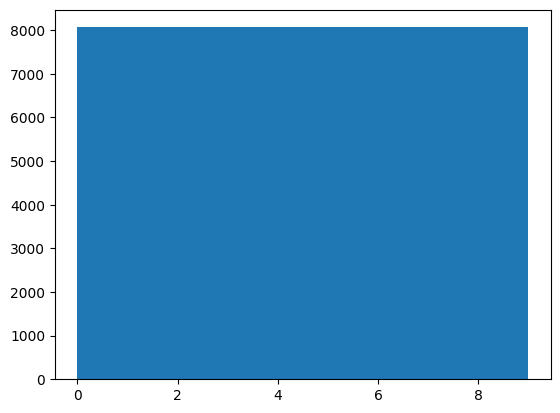

In [ ]:
# Balancing the data by downsampling
def balance_data(noise_samples, predicted_classes):
    """Balances the dataset by downsampling the over-represented classes."""
    class_counts = np.bincount(predicted_classes)
    min_count = np.min(class_counts)
    balanced_noise_samples = []
    balanced_predicted_classes = []

    for class_label in range(len(class_counts)):
        # Get indices of samples belonging to the current class
        class_indices = np.where(predicted_classes == class_label)[0]
        # Randomly sample `min_count` indices from the class
        sampled_indices = np.random.choice(class_indices, size=min_count, replace=False)
        # Append the corresponding data to the balanced lists
        balanced_noise_samples.extend(noise_samples[sampled_indices])
        balanced_predicted_classes.extend(predicted_classes[sampled_indices])

    return np.array(balanced_noise_samples), np.array(balanced_predicted_classes)

balanced_noise_samples, balanced_predicted_classes = balance_data(all_filtered_data, all_filtered_preds)
import matplotlib.pyplot as plt
plt.hist(balanced_predicted_classes, bins=10)

/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 0.3117, Train Accuracy: 89.16 %, Test Loss: 0.1876, Test Accuracy: 93.44 %
Epoch [2/30], Train Loss: 0.1319, Train Accuracy: 95.39 %, Test Loss: 0.1234, Test Accuracy: 95.68 %
Epoch [3/30], Train Loss: 0.0925, Train Accuracy: 96.70 %, Test Loss: 0.1445, Test Accuracy: 95.21 %
Epoch [4/30], Train Loss: 0.0732, Train Accuracy: 97.43 %, Test Loss: 0.1068, Test Accuracy: 96.34 %
Epoch [5/30], Train Loss: 0.0586, Train Accuracy: 97.94 %, Test Loss: 0.1180, Test Accuracy: 96.13 %
Epoch [6/30], Train Loss: 0.0489, Train Accuracy: 98.32 %, Test Loss: 0.0938, Test Accuracy: 96.85 %
Epoch [7/30], Train Loss: 0.0422, Train Accuracy: 98.52 %, Test Loss: 0.1014, Test Accuracy: 96.73 %
Epoch [8/30], Train Loss: 0.0355, Train Accuracy: 98.78 %, Test Loss: 0.1141, Test Accuracy: 96.52 %
Epoch [9/30], Train Loss: 0.0333, Train Accuracy: 98.84 %, Test Loss: 0.0885, Test Accuracy: 97.12 %
Epoch [10/30], Train Loss: 0.0286, Train Accuracy: 99.00 %, Test Loss: 0.0980, Test Accurac

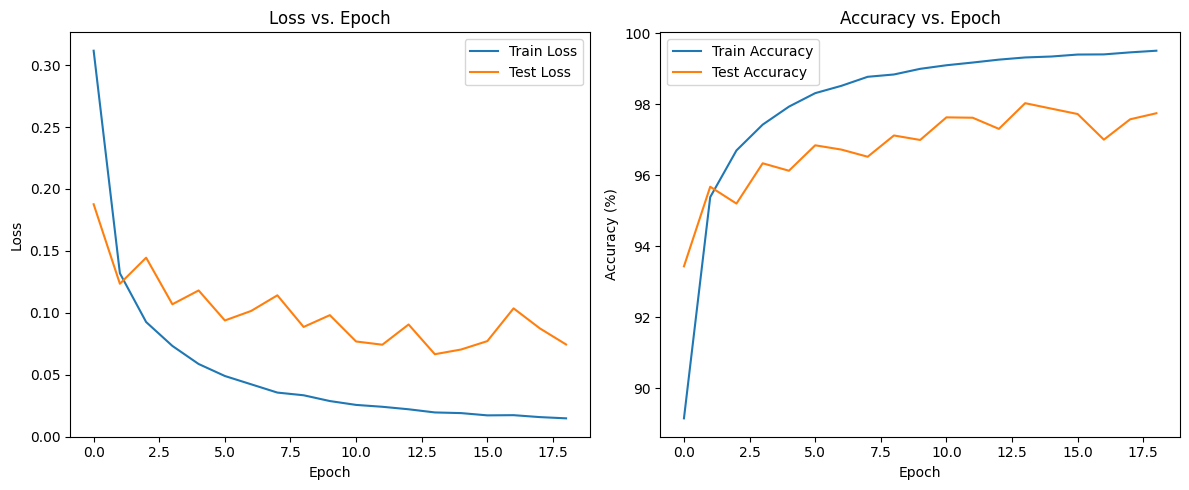

Best model saved to student_mnistcnn_model_best.pth


In [ ]:


class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Adjust first convolution for 1 channel (grayscale) and 3x3 kernel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove maxpool layer
        self.resnet.maxpool = nn.Identity()
        # Adjust final layer for MNIST classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# 2. Instantiate the Model
model = CNNModel()

# 3. Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Hyperparameters
num_epochs = 30  # Increased number of epochs for early stopping
batch_size = 100
learning_rate = 0.001
patience = 5  # Number of epochs to wait for improvement

# 5. MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
noise_samples = torch.tensor(all_filtered_data, dtype=torch.float32)
predicted_classes = torch.tensor(all_filtered_preds, dtype=torch.long)
# noise_samples = torch.tensor(balanced_noise_samples, dtype=torch.float32)
# predicted_classes = torch.tensor(balanced_predicted_classes, dtype=torch.long)

# Create TensorDataset for each pair of data and labels
# dataset1 = TensorDataset(noise_samples, predicted_classes)
# dataset2 = TensorDataset(noise_samples_, predicted_classes_)

# Concatenate the datasets
# combined_dataset = dataset1#ConcatDataset([dataset1, dataset2])

# Now combined_dataset is a single dataset that contains all the samples and labels

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    noise_samples, predicted_classes, test_size=0.2, random_state=42)#, stratify=predicted_classes)



# Option 2: If you need more complex transforms, create a custom dataset class
class CustomTensorDataset(Dataset):
    def __init__(self, x_tensor, y_tensor, transform=None):
        self.x = x_tensor
        self.y = y_tensor
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

# Define your transforms
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets with custom class
train_dataset = CustomTensorDataset(X_train, y_train)#, transform=transform)
test_dataset = CustomTensorDataset(X_test, y_test)

# train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 6. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 7. Training Loop with Tracking and Early Stopping
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

best_test_loss = float('inf')  # Initialize with a very high value
epochs_no_improve = 0
best_model_state = None # Store the best model

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f} %, Test Loss: {:.4f}, Test Accuracy: {:.2f} %'
          .format(epoch + 1, num_epochs, train_loss, train_accuracy, test_loss, test_accuracy))

    # Early Stopping Check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the best model so far
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered!")
            break  # Exit the training loop

# 8. Plotting the Results
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Save the Best Model
if best_model_state is not None:
    torch.save(best_model_state, 'student_mnistcnn_model_best.pth') # Save the state dict of the best model
    print("Best model saved to student_mnistcnn_model_best.pth")
else:
    print("No improvement during training, saving last model state")
    torch.save(model.state_dict(), 'student_mnistcnn_model_best.pth') # save final model if there was no improvement.

/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/libra-04/devanand/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_6169/2134378770.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#unt

Accuracy of the student model on the MNIST test images: 95.77%


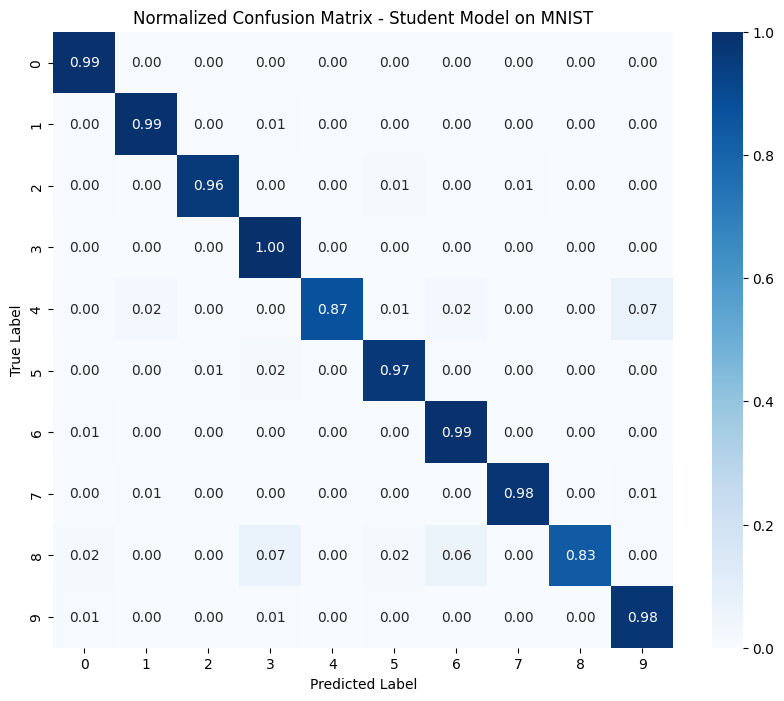

In [ ]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Adjust first convolution for 1 channel (grayscale) and 3x3 kernel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Remove maxpool layer
        self.resnet.maxpool = nn.Identity()
        # Adjust final layer for MNIST classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Load the trained student model
student_model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)
student_model.load_state_dict(torch.load('student_mnistcnn_model_best.pth', map_location=device))

student_model.eval()
student_params = count_parameters(student_model)

# Load MNIST test data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the student model
correct = 0
total = 0
all_predicted = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the student model on the MNIST test images: {accuracy:.2f}%')

# Compute confusion matrix
confusion_mat = confusion_matrix(all_labels, all_predicted)

# Normalize the confusion matrix
confusion_mat_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
class_names = ['0', '1', '2', '3', '4',
                     '5', '6', '7', '8', '9']
# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_normalized, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix - Student Model on MNIST")
plt.show()